In [24]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

class CustomDataset(Dataset):
    def __init__(self, image_paths, patch_size=33, stride=14, is_train=True, upscale_factor=3):
        self.image_paths = image_paths
        self.is_train = is_train
        self.upscale_factor = upscale_factor
        self.transform = transforms.ToTensor()
        
        self.patches = []

        for img_path in image_paths:
            img = Image.open(img_path).convert('RGB')
            if self.is_train:
                for i in range(0, img.height - patch_size + 1, stride):
                    for j in range(0, img.width - patch_size + 1, stride):
                        patch = img.crop((j, i, j + patch_size, i + patch_size))
                        hr_patch = self.transform(patch)
                        lr_patch = patch.resize((patch.width // upscale_factor, patch.height // upscale_factor), Image.BICUBIC)
                        lr_patch = lr_patch.resize((lr_patch.width * upscale_factor, lr_patch.height * upscale_factor), Image.BICUBIC)
                        lr_patch = self.transform(lr_patch)
                        self.patches.append((lr_patch, hr_patch))
            else:
                lr_img = img.resize((img.width // upscale_factor, img.height // upscale_factor), Image.BICUBIC)
                lr_img = lr_img.resize((lr_img.width * upscale_factor, lr_img.height * upscale_factor), Image.BICUBIC)
                self.patches.append((self.transform(lr_img), self.transform(img)))

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        return self.patches[idx]

def collate_fn(batch):
    lr_images, hr_images = zip(*batch)
    return torch.stack(lr_images), torch.stack(hr_images)

class SuperResolutionModel(nn.Module):
    def __init__(self):
        super(SuperResolutionModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=0)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, stride=1, padding=0)
        self.relu = nn.ReLU()
        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0.0, std=0.001)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

def train(model, train_loader, criterion, optimizer, device, epoch, writer):
    model.train()
    running_loss = 0.0
    crop_size = 21
    center_crop = transforms.CenterCrop(crop_size)

    for i, (lr_patches, hr_patches) in enumerate(train_loader):
        lr_patches = lr_patches.to(device)
        hr_patches = hr_patches.to(device)

        optimizer.zero_grad()
        outputs = model(lr_patches)
        hr_patches_cropped = torch.stack([center_crop(hr_patch) for hr_patch in hr_patches])

        loss = criterion(outputs, hr_patches_cropped)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if (i + 1) % 345 == 0:
            processed_images = (i + 1) * lr_patches.size(0)
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}, Processed Images: {processed_images}")
            writer.add_images('Train/LR', lr_patches[:4], epoch * len(train_loader) + i)
            writer.add_images('Train/SR', outputs[:4], epoch * len(train_loader) + i)
            writer.add_images('Train/HR', hr_patches[:4], epoch * len(train_loader) + i)

    avg_loss = running_loss / len(train_loader)
    writer.add_scalar('Loss/Train', avg_loss, epoch)
    return avg_loss

def evaluate(model, val_loader, criterion, device, epoch, writer):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, (lr_image, hr_image) in enumerate(val_loader):
            lr_image = lr_image.to(device)
            hr_image = hr_image.to(device)
            output = model(lr_image)

            _, _, out_h, out_w = output.size()
            hr_cropped = hr_image[:, :, (hr_image.size(2) - out_h) // 2:(hr_image.size(2) + out_h) // 2,
                                  (hr_image.size(3) - out_w) // 2:(hr_image.size(3) + out_w) // 2]

            loss = criterion(output, hr_cropped)
            total_loss += loss.item()

            if (i + 1) % 19 == 0:
                processed_images = (i + 1) * lr_image.size(0)
                print(f"Validation Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(val_loader)}], Loss: {loss.item():.4f}, Processed Images: {processed_images}")
                writer.add_images('Val/LR', lr_image, epoch)
                writer.add_images('Val/SR', output, epoch)
                writer.add_images('Val/HR', hr_cropped, epoch)

    avg_loss = total_loss / len(val_loader)
    writer.add_scalar('Loss/Validation', avg_loss, epoch)
    return avg_loss

def compare_images(lr_image, sr_image, hr_image, save_path):
    lr_image = transforms.ToPILImage()(lr_image.squeeze(0).cpu())
    sr_image = transforms.ToPILImage()(sr_image.squeeze(0).cpu())
    hr_image = transforms.ToPILImage()(hr_image.squeeze(0).cpu())

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Bicubic 3x')
    plt.imshow(lr_image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('SRCNN')
    plt.imshow(sr_image)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Original')
    plt.imshow(hr_image)
    plt.axis('off')

    plt.savefig(save_path)
    plt.close()

def save_model(model, epoch, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved at epoch {epoch}")

def test_model(model, test_loader, device, epoch, result_folder):
    model.eval()
    os.makedirs(result_folder, exist_ok=True)

    for img_path in test_loader.dataset.image_paths:
        lr_image = Image.open(img_path).convert('RGB')
        hr_image = Image.open(img_path.replace('LRbicx3', 'GTmod12')).convert('RGB')

        lr_tensor = transforms.ToTensor()(lr_image).unsqueeze(0).to(device)
        hr_tensor = transforms.ToTensor()(hr_image).unsqueeze(0).to(device)

        with torch.no_grad():
            sr_tensor = model(lr_tensor)

        save_path = os.path.join(result_folder, f'{os.path.splitext(os.path.basename(img_path))[0]}_epoch_{epoch}_comparison.png')
        compare_images(lr_tensor, sr_tensor, hr_tensor, save_path)

    print(f"Testing complete for epoch {epoch}. Results saved in the result folder.")

if __name__ == "__main__":
    batch_size = 16
    epochs = 10000

    train_folder = 'T91'
    val_folder_1 = 'GTmod12'
    val_folder_2 = 'GTmod12'
    lr_folder = 'LRbicx3'
    hr_folder = 'GTmod12'
    result_folder = 'result'

    train_image_paths = [os.path.join(train_folder, img) for img in os.listdir(train_folder)]
    val_image_paths_1 = [os.path.join(val_folder_1, img) for img in os.listdir(val_folder_1)]
    val_image_paths_2 = [os.path.join(val_folder_2, img) for img in os.listdir(val_folder_2)]
    test_image_paths = [os.path.join(lr_folder, img) for img in os.listdir(lr_folder)]

    train_dataset = CustomDataset(train_image_paths, is_train=True)
    val_dataset_1 = CustomDataset(val_image_paths_1, is_train=False)
    val_dataset_2 = CustomDataset(val_image_paths_2, is_train=False)
    
    # Combine the validation datasets
    combined_val_dataset = ConcatDataset([val_dataset_1, val_dataset_2])
    
    test_dataset = CustomDataset(test_image_paths, is_train=False)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
    val_loader = DataLoader(combined_val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, drop_last=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, drop_last=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SuperResolutionModel().to(device)
    criterion = nn.MSELoss()

    train_writer = SummaryWriter(f'runs/super_resolution_experiment/train_bs_{batch_size}_epochs_{epochs}')
    val_writer = SummaryWriter(f'runs/super_resolution_experiment/val_bs_{batch_size}_epochs_{epochs}')
    
    optimizer = optim.SGD([
        {'params': model.conv1.parameters(), 'lr': 1e-4},
        {'params': model.conv2.parameters(), 'lr': 1e-4},
        {'params': model.conv3.parameters(), 'lr': 1e-5},
    ], momentum=0.9)

    save_interval = 100

    for epoch in range(epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device, epoch, train_writer)
        val_loss = evaluate(model, val_loader, criterion, device, epoch, val_writer)
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if (epoch + 1) % save_interval == 0:
            save_path = f"model_{batch_size}_{epoch+1}.pth"
            save_model(model, epoch + 1, save_path)
            test_model(model, test_loader, device, epoch + 1, result_folder)

    train_writer.close()
    val_writer.close()


Epoch [1/10000], Step [345/1380], Loss: 0.3024, Processed Images: 5520
Epoch [1/10000], Step [690/1380], Loss: 0.2330, Processed Images: 11040
Epoch [1/10000], Step [1035/1380], Loss: 0.2036, Processed Images: 16560
Epoch [1/10000], Step [1380/1380], Loss: 0.2270, Processed Images: 22080
Validation Epoch [1/10000], Step [19/19], Loss: 0.2260, Processed Images: 19
Epoch [2/10000], Step [345/1380], Loss: 0.2755, Processed Images: 5520
Epoch [2/10000], Step [690/1380], Loss: 0.2314, Processed Images: 11040
Epoch [2/10000], Step [1035/1380], Loss: 0.2158, Processed Images: 16560
Epoch [2/10000], Step [1380/1380], Loss: 0.2340, Processed Images: 22080
Validation Epoch [2/10000], Step [19/19], Loss: 0.1956, Processed Images: 19
Epoch [3/10000], Step [345/1380], Loss: 0.1639, Processed Images: 5520
Epoch [3/10000], Step [690/1380], Loss: 0.2096, Processed Images: 11040
Epoch [3/10000], Step [1035/1380], Loss: 0.1428, Processed Images: 16560
Epoch [3/10000], Step [1380/1380], Loss: 0.1633, Pro

KeyboardInterrupt: 

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.save(model.state_dict(), "C:\\Users\\hauru\\SRCNN\\data\\testSet\\Set5\\Set5\\model_trained\\srcnnFinal.pth")
print("Saved PyTorch Model State to srcnn2.pth")
model = SuperResolutionModel().to(device)
model.load_state_dict(torch.load("C:\\Users\\hauru\\SRCNN\\data\\testSet\\Set5\\Set5\\model_trained\\srcnnFinal.pth"))

Saved PyTorch Model State to srcnn2.pth


<All keys matched successfully>

LR Image Tensor Shape: torch.Size([1, 3, 252, 252])
HR Image Tensor Shape: torch.Size([1, 3, 252, 252])
SR Image Tensor Shape: torch.Size([3, 240, 240])
LR Image PIL Size: (252, 252)
SR Image PIL Size: (240, 240)
HR Image PIL Size: (252, 252)


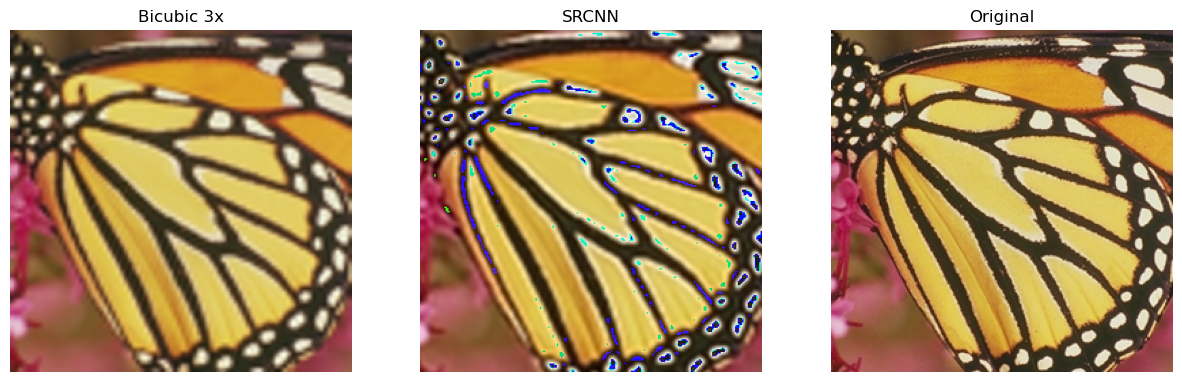

In [33]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Paths
lr_folder = 'C:\\Users\\hauru\\SRCNN\\data\\testSet\\Set5\\Set5\\LRbicx3'
hr_folder = 'C:\\Users\\hauru\\SRCNN\\data\\testSet\\Set5\\Set5\\GTmod12'
result_folder = 'C:\\Users\\hauru\\SRCNN\\data\\testSet\\Set5\\Set5\\result'

# Load images
lr_image_path = os.path.join(lr_folder, 'butterfly.png')
hr_image_path = os.path.join(hr_folder, 'butterfly.png')

lr_image = Image.open(lr_image_path)
hr_image = Image.open(hr_image_path)

lr_image = lr_image.resize((hr_image.width, hr_image.height), Image.BICUBIC)

to_tensor = transforms.ToTensor()
lr_image_tensor = to_tensor(lr_image).unsqueeze(0).to(device)
hr_image_tensor = to_tensor(hr_image).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    sr_image_tensor = model(lr_image_tensor).squeeze(0)

to_pil = transforms.ToPILImage()
lr_image_pil = to_pil(lr_image_tensor.squeeze(0).cpu())
sr_image_pil = to_pil(sr_image_tensor.cpu())
hr_image_pil = to_pil(hr_image_tensor.squeeze(0).cpu())

print(f"LR Image Tensor Shape: {lr_image_tensor.shape}")
print(f"HR Image Tensor Shape: {hr_image_tensor.shape}")
print(f"SR Image Tensor Shape: {sr_image_tensor.shape}")
print(f"LR Image PIL Size: {lr_image_pil.size}")
print(f"SR Image PIL Size: {sr_image_pil.size}")
print(f"HR Image PIL Size: {hr_image_pil.size}")

# Save the images
os.makedirs(result_folder, exist_ok=True)
lr_image_pil.save(os.path.join(result_folder, 'butterfly_lr.png'))
sr_image_pil.save(os.path.join(result_folder, 'butterfly_sr.png'))
hr_image_pil.save(os.path.join(result_folder, 'butterfly_gt.png'))

# Display the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Bicubic 3x')
plt.imshow(lr_image_pil)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('SRCNN')
plt.imshow(sr_image_pil)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Original')
plt.imshow(hr_image_pil)
plt.axis('off')

plt.show()
